# Search Algorithms

:label:`course_alg`


## AutoGluon System Implementatin Logic

![](https://raw.githubusercontent.com/zhanghang1989/AutoGluonWebdata/master/doc/api/autogluon_system.png)

Important components of the AutoGluon system include the Searcher, Scheduler and Resource Manager:

- The Searcher suggests hyperparameter configurations for the next training job.
- The Scheduler runs the training job when computation resources become available.

In this tutorial, we illustrate how various search algorithms work and
compare their performance via toy experiments.

## FIFO Scheduling vs. Early Stopping

In this section, we compare the different behaviors of a sequential First In, First Out (FIFO) scheduler using :class:`autogluon.scheduler.FIFOScheduler` vs. a preemptive scheduling algorithm
:class:`autogluon.scheduler.HyperbandScheduler` that early-terminates certain training jobs that do not appear promising during their early stages.

### Create a Dummy Training Function

In [1]:
import numpy as np
import autogluon as ag

@ag.args(
    lr=ag.space.Real(1e-3, 1e-2, log=True),
    wd=ag.space.Real(1e-3, 1e-2))
def train_fn(args, reporter):
    for e in range(10):
        dummy_accuracy = 1 - np.power(1.8, -np.random.uniform(e, 2*e))
        reporter(epoch=e, accuracy=dummy_accuracy, lr=args.lr, wd=args.wd)

### FIFO Scheduler

This scheduler runs training trials in order. When there are more resources available than required for a single training job, multiple training jobs may be run in parallel.

In [2]:
scheduler = ag.scheduler.FIFOScheduler(train_fn,
                                       resource={'num_cpus': 2, 'num_gpus': 0},
                                       num_trials=20,
                                       reward_attr='accuracy',
                                       time_attr='epoch')
scheduler.run()
scheduler.join_jobs()


Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 20


Finished Task with config: {'lr': 0.001699978575652119, 'wd': 0.008528433271580206} and reward: 0.9997084979745358
Finished Task with config: {'lr': 0.0031622777, 'wd': 0.0055} and reward: 0.9987710776248258
Finished Task with config: {'lr': 0.0020824578291517657, 'wd': 0.002692725999498675} and reward: 0.9995104379366804
Finished Task with config: {'lr': 0.0074318075869177465, 'wd': 0.0027154876167144} and reward: 0.9994946008106337
Finished Task with config: {'lr': 0.003195389822319378, 'wd': 0.003144440530016585} and reward: 0.9998127858805036
Finished Task with config: {'lr': 0.005837544721671418, 'wd': 0.003844465602446181} and reward: 0.9981324732151834
Finished Task with config: {'lr': 0.0029375941220022264, 'wd': 0.0022430174442521524} and reward: 0.9999440389170993
Finished Task with config: {'lr': 0.0012682319285121876, 'wd': 0.009720627160440441} and reward: 0.9995987038392062
Finished Task with config: {'lr': 0.001976203296302553, 'wd': 0.007872251092690042} and reward: 0.9

Finished Task with config: {'lr': 0.005735325479582829, 'wd': 0.009624051731582584} and reward: 0.997560417275033
Finished Task with config: {'lr': 0.0030061011628006273, 'wd': 0.008789246171927546} and reward: 0.9984360433059107
Finished Task with config: {'lr': 0.004230896291819586, 'wd': 0.006961502757979984} and reward: 0.9998894026211204
Finished Task with config: {'lr': 0.001114092886317859, 'wd': 0.009049394468293954} and reward: 0.9999652768067441
Finished Task with config: {'lr': 0.005952377441699535, 'wd': 0.00956906826225052} and reward: 0.9986559472047832
Finished Task with config: {'lr': 0.0013435361875358462, 'wd': 0.0037016488812713928} and reward: 0.9992405701254338
Finished Task with config: {'lr': 0.0054344874264366915, 'wd': 0.0032376642046260547} and reward: 0.9956597381250288
Finished Task with config: {'lr': 0.0016379894056052957, 'wd': 0.002195323452854096} and reward: 0.9998253586497194
Finished Task with config: {'lr': 0.0014620864380807546, 'wd': 0.00534169497

Visualize the results:

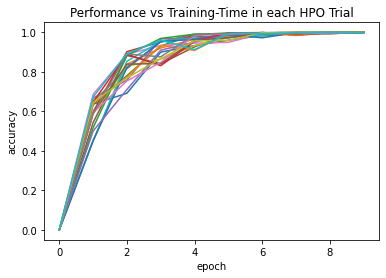

In [3]:
scheduler.get_training_curves(plot=True, use_legend=False)

### Hyperband Scheduler

The Hyperband Scheduler terminates training trials that don't appear promising during the early stages to free up compute resources for more promising hyperparameter configurations.

In [4]:
scheduler = ag.scheduler.HyperbandScheduler(train_fn,
                                            resource={'num_cpus': 2, 'num_gpus': 0},
                                            num_trials=20,
                                            reward_attr='accuracy',
                                            time_attr='epoch',
                                            grace_period=1)
scheduler.run()
scheduler.join_jobs()


Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 20


Finished Task with config: {'lr': 0.002321567870381807, 'wd': 0.005786613369405488} and reward: 0.5814305151509747
Finished Task with config: {'lr': 0.0019947085351685115, 'wd': 0.008065765480333833} and reward: 0.6317342739756673
Finished Task with config: {'lr': 0.0031622777, 'wd': 0.0055} and reward: 0.5312667649768057
Finished Task with config: {'lr': 0.006065519424149765, 'wd': 0.009095622723796406} and reward: 0.6054625760180542
Finished Task with config: {'lr': 0.0016874292702514563, 'wd': 0.008473985092893824} and reward: 0.5906063229485552
Finished Task with config: {'lr': 0.0063284627505254005, 'wd': 0.004425278505970314} and reward: 0.600553651320286
Finished Task with config: {'lr': 0.005984574498099353, 'wd': 0.00947275455958074} and reward: 0.9994296287730586
Finished Task with config: {'lr': 0.0030711626003067163, 'wd': 0.005142950964055412} and reward: 0.5301071514197571
Finished Task with config: {'lr': 0.001470251641438256, 'wd': 0.0012336720601854644} and reward: 0.5

Visualize the results:

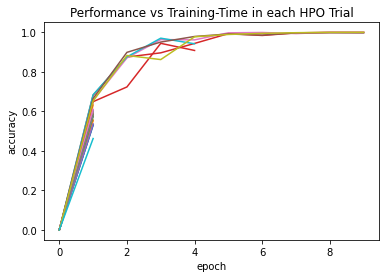

In [5]:
scheduler.get_training_curves(plot=True, use_legend=False)

## Random Search vs. Reinforcement Learning

In this section, we demonstrate the behaviors of random search and reinforcement learning
in a simple simulation environment.

### Create a Reward Function for Toy Experiments

Import the packages:

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Input Space `x = [0: 99], y = [0: 99]`.
The rewards is a combination of 2 gaussians as shown in the following figure:

Generate the simulated reward as a mixture of 2 gaussians:

In [7]:
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A): 
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2) 

x, y = np.linspace(0, 99, 100), np.linspace(0, 99, 100) 
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape) 
ps = [(20, 70, 35, 40, 1),
      (80, 40, 20, 20, 0.7)]
for p in ps:
    Z += gaussian2d(X, Y, *p)

Visualize the reward space:

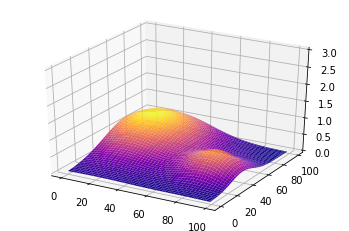

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, cmap='plasma') 
ax.set_zlim(0,np.max(Z)+2)
plt.show()

### Create Training Function

We can simply define an AutoGluon searchable function with a decorator `ag.args`.
The `reporter` is used to communicate with AutoGluon search and scheduling algorithms.

In [9]:
@ag.args(
    x=ag.space.Categorical(*list(range(100))),
    y=ag.space.Categorical(*list(range(100))),
)
def rl_simulation(args, reporter):
    x, y = args.x, args.y
    reporter(accuracy=Z[y][x])

### Random Search

In [10]:
random_scheduler = ag.scheduler.FIFOScheduler(rl_simulation,
                                              resource={'num_cpus': 1, 'num_gpus': 0},
                                              num_trials=300,
                                              reward_attr="accuracy",
                                              resume=False)
random_scheduler.run()
random_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(random_scheduler.get_best_config(), random_scheduler.get_best_reward()))

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 300


Finished Task with config: {'x.choice': 39, 'y.choice': 34} and reward: 0.34088178289245097
Finished Task with config: {'x.choice': 0, 'y.choice': 0} and reward: 0.033741370964360654
Finished Task with config: {'x.choice': 0, 'y.choice': 82} and reward: 0.659330329862526
Finished Task with config: {'x.choice': 1, 'y.choice': 36} and reward: 0.3616083474072007
Finished Task with config: {'x.choice': 79, 'y.choice': 3} and reward: 0.026311672957427246
Finished Task with config: {'x.choice': 46, 'y.choice': 84} and reward: 0.5098018492977304
Finished Task with config: {'x.choice': 6, 'y.choice': 46} and reward: 0.5945212732742058
Finished Task with config: {'x.choice': 66, 'y.choice': 33} and reward: 0.45494507454620514
Finished Task with config: {'x.choice': 71, 'y.choice': 78} and reward: 0.13041417772231312
Finished Task with config: {'x.choice': 81, 'y.choice': 27} and reward: 0.4727371058643541
Finished Task with config: {'x.choice': 64, 'y.choice': 44} and reward: 0.4895741725321769

Finished Task with config: {'x.choice': 39, 'y.choice': 57} and reward: 0.6751902384932484
Finished Task with config: {'x.choice': 66, 'y.choice': 9} and reward: 0.05617688520112782


Best config: {'x.choice': 19, 'y.choice': 66}, best reward: 0.9892537387967879


### Reinforcement Learning

In [11]:
rl_scheduler = ag.scheduler.RLScheduler(rl_simulation,
                                        resource={'num_cpus': 1, 'num_gpus': 0},
                                        num_trials=300,
                                        reward_attr="accuracy",
                                        controller_batch_size=4,
                                        controller_lr=5e-3)
rl_scheduler.run()
rl_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(rl_scheduler.get_best_config(), rl_scheduler.get_best_reward()))

Reserved DistributedResource(
	Node = Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.86.165/18657/1' processes=1 threads=32, memory=257.79 GB>
	nCPUs = 0) in Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.86.165/18657/1' processes=1 threads=32, memory=257.79 GB>
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 300


Finished Task with config: {'x.choice': 54, 'y.choice': 60} and reward: 0.4131320021194963
Finished Task with config: {'x.choice': 59, 'y.choice': 85} and reward: 0.25248241948989986
Finished Task with config: {'x.choice': 71, 'y.choice': 54} and reward: 0.452177348673922
Finished Task with config: {'x.choice': 84, 'y.choice': 84} and reward: 0.03655423885462522
Finished Task with config: {'x.choice': 42, 'y.choice': 43} and reward: 0.44561928050295485
Finished Task with config: {'x.choice': 62, 'y.choice': 29} and reward: 0.3129734289166378
Finished Task with config: {'x.choice': 64, 'y.choice': 89} and reward: 0.16521724999224768
Finished Task with config: {'x.choice': 38, 'y.choice': 5} and reward: 0.055140459703497166
Finished Task with config: {'x.choice': 96, 'y.choice': 79} and reward: 0.01675323386032184
Finished Task with config: {'x.choice': 27, 'y.choice': 80} and reward: 0.9025895808289532
Finished Task with config: {'x.choice': 38, 'y.choice': 52} and reward: 0.63282275329


Best config: {'x.choice': 21, 'y.choice': 74}, best reward: 0.9892484241569526


### Compare the performance

Get the result history:

In [12]:
results_rl = [v[0]['accuracy'] for v in rl_scheduler.training_history.values()]
results_random = [v[0]['accuracy'] for v in random_scheduler.training_history.values()]

Average result every 10 trials:

In [13]:
import statistics
results1 = [statistics.mean(results_random[i:i+10]) for i in range(0, len(results_random), 10)]
results2 = [statistics.mean(results_rl[i:i+10]) for i in range(0, len(results_rl), 10)]

Plot the results:

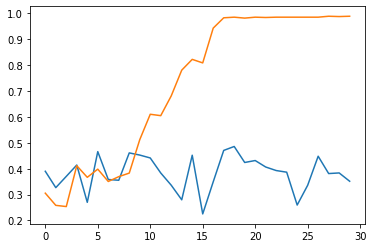

In [14]:
plt.plot(range(len(results1)), results1, range(len(results2)), results2)